In [1]:
!pip install gensim

    100% |################################| 22.6MB 78kB/s  eta 0:00:01
    100% |################################| 1.4MB 1.3MB/s eta 0:00:01
    100% |################################| 92kB 13.5MB/s ta 0:00:01
    100% |################################| 133kB 10.3MB/s ta 0:00:01
    100% |################################| 61kB 13.3MB/s ta 0:00:01
    100% |################################| 153kB 7.8MB/s eta 0:00:01
    100% |################################| 143kB 8.4MB/s eta 0:00:01
    100% |################################| 133kB 9.2MB/s eta 0:00:01
    100% |################################| 4.2MB 441kB/s eta 0:00:01
    100% |################################| 61kB 13.1MB/s ta 0:00:01
    100% |################################| 552kB 3.2MB/s eta 0:00:01
  Running setup.py bdist_wheel for smart-open ... done
  Stored in directory: /root/.cache/pip/wheels/cf/54/36/b003d8c2d26aadffc21f0677009ed53cf9575a97fc71fbba76
  Running setup.py bdist_wheel for bz2file ... done
  Stored in direct

In [2]:
!pip install nltk

    100% |################################| 1.2MB 1.3MB/s eta 0:00:01
  Running setup.py bdist_wheel for nltk ... done
  Stored in directory: /root/.cache/pip/wheels/18/9c/1f/276bc3f421614062468cb1c9d695e6086d0c73d67ea363c501
Successfully built nltk
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
!pip install keras

    100% |################################| 337kB 3.2MB/s ta 0:00:01
    100% |################################| 256kB 4.0MB/s ta 0:00:01
  Running setup.py bdist_wheel for pyyaml ... done
  Stored in directory: /root/.cache/pip/wheels/2c/f7/79/13f3a12cd723892437c0cfbde1230ab4d82947ff7b3839a4fc
Successfully built pyyaml
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
!pip install tqdm

    100% |################################| 51kB 3.7MB/s ta 0:00:011
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
import re
import json
import fileinput
import pandas as pd
import gensim
import numpy as np
import nltk
import os
import random
import sklearn.metrics
import sklearn.model_selection
from sklearn.manifold import TSNE
import sklearn.datasets
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from gensim.models.word2vec import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize, sent_tokenize, TweetTokenizer
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, confusion_matrix
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
seed = 7
np.random.seed(seed)

In [7]:
df = pd.read_csv('train_labeled_data.csv', encoding='ISO-8859-1', header = None)

In [8]:
df.columns = ["sentiment_label", "tweet_id", "date", "flag", "user", "tweet"]

In [9]:
df.drop(['tweet_id', 'date', 'flag', 'user'], axis=1, inplace=True)

In [10]:
df1 = df[df.sentiment_label.isnull() == False]

In [11]:
df1 = df[df.tweet.isnull() == False]

In [12]:
df1.reset_index(inplace=True)

In [13]:
df1.drop('index', axis=1, inplace=True)

In [14]:
df1['sentiment_label'] = df1['sentiment_label'].map( {4:1, 0:0} )

In [15]:
# Extract features from a given text
def extract_tokens(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = list(filter(lambda t: not t.startswith('@'), tokens))
    tokens = list(filter(lambda t: not t.startswith('#'), tokens))
    tokens = list(filter(lambda t: not t.startswith('http'), tokens))
    
    return tokens

In [16]:
def data_process(data):
    data['tokens'] = data['tweet'].map(extract_tokens)
    
    return data

In [17]:
df1 = data_process(df1)

In [18]:
df1 = df1[df1.tokens != 'NC']
df1.reset_index(inplace=True)
df1.drop('index', inplace=True, axis=1)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(np.array(df1.tokens), np.array(df1.sentiment_label), test_size=0.2)

In [20]:
lsentence = gensim.models.doc2vec.LabeledSentence

In [21]:
def label_tweets(text, ltype):
    labelized = []
    for i,v in tqdm(enumerate(text)):
        label = '%s_%s'%(ltype,i)
        labelized.append(lsentence(v, [label]))
    return labelized

In [22]:
x_train = label_tweets(x_train, 'TRAIN')
x_test = label_tweets(x_test, 'TEST')

0it [00:00, ?it/s]/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  """
1280000it [00:09, 140219.37it/s]
320000it [00:02, 113345.04it/s]


In [23]:
x_train[0]

LabeledSentence(words=['i', 'need', 'friends'], tags=['TRAIN_0'])

In [24]:
n_dim = 500

In [25]:
w2v_model = Word2Vec(size=n_dim, min_count=10)
w2v_model.build_vocab([x.words for x in tqdm(x_train)])
w2v_model.train([x.words for x in tqdm(x_train)], total_examples = w2v_model.corpus_count, epochs = w2v_model.iter )

100%|██████████| 1280000/1280000 [00:00<00:00, 1404857.82it/s]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  This is separate from the ipykernel package so we can avoid doing imports until


(69388646, 94161350)

In [26]:
w2v_model.most_similar('good')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('great', 0.7373624444007874),
 ('goood', 0.7336056232452393),
 ('rough', 0.6671867370605469),
 ('goooood', 0.6581369042396545),
 ('fab', 0.6456925868988037),
 ('nice', 0.6389963626861572),
 ('tough', 0.638160228729248),
 ('gooood', 0.6375186443328857),
 ('fantastic', 0.6268146634101868),
 ('terrible', 0.6239801645278931)]

In [27]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens[:100])

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


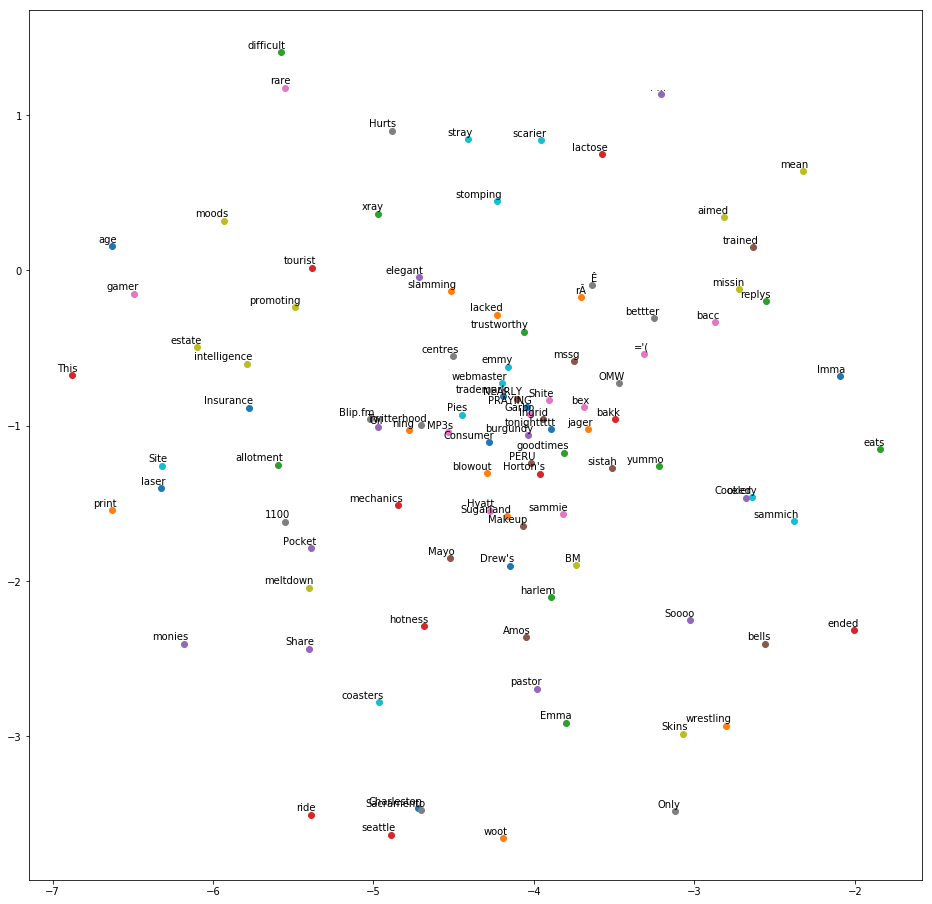

In [28]:
tsne_plot(w2v_model)

In [29]:
build_matrix = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
tfidf_matrix = build_matrix.fit_transform([x.words for x in x_train])
tfidf = dict(zip(build_matrix.get_feature_names(), build_matrix.idf_))

In [30]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += w2v_model[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [31]:
train_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x.words, x_train))])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, n_dim) for z in tqdm(map(lambda x: x.words, x_test))])
test_vecs_w2v = scale(test_vecs_w2v)

0it [00:00, ?it/s]/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
1280000it [03:53, 5485.43it/s]
320000it [00:58, 5457.58it/s]


In [32]:
def classifier_model():
    model = Sequential()
    model.add(Dense(32, activation='relu', input_dim=500))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
  
    return model

#model.fit(train_vecs_w2v, train_vecs_w2v, validation_split=0.33, epochs=9, batch_size=32, verbose=2)

In [33]:
estimator = KerasClassifier(build_fn=classifier_model, epochs=4, batch_size=32, verbose=2)

In [34]:
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

In [35]:
results = cross_val_score(estimator, train_vecs_w2v, y_train, cv=kfold)
print("Model: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/4
 - 89s - loss: 0.4611 - acc: 0.7824
Epoch 2/4
 - 87s - loss: 0.4479 - acc: 0.7903
Epoch 3/4
 - 87s - loss: 0.4436 - acc: 0.7929
Epoch 4/4
 - 86s - loss: 0.4415 - acc: 0.7940
Epoch 1/4
 - 88s - loss: 0.4611 - acc: 0.7821
Epoch 2/4
 - 89s - loss: 0.4478 - acc: 0.7903
Epoch 3/4
 - 88s - loss: 0.4439 - acc: 0.7927
Epoch 4/4
 - 86s - loss: 0.4416 - acc: 0.7938
Epoch 1/4
 - 87s - loss: 0.4607 - acc: 0.7831
Epoch 2/4
 - 87s - loss: 0.4474 - acc: 0.7904
Epoch 3/4
 - 88s - loss: 0.4434 - acc: 0.7929
Epoch 4/4
 - 88s - loss: 0.4409 - acc: 0.7943
Epoch 1/4
 - 89s - loss: 0.4606 - acc: 0.7826
Epoch 2/4
 - 89s - loss: 0.4477 - acc: 0.7905
Epoch 3/4
 - 86s - loss: 0.4437 - acc: 0.7928
Epoch 4/4
 - 87s - loss: 0.4414 - acc: 0.7945
Epoch 1/4
 - 88s - loss: 0.4611 - acc: 0.7821
Epoch 2/4
 - 88s - loss: 0.4474 - acc: 0.7906
Epoch 3/4
 - 88s - loss: 0.4436 - acc: 0.7927
Epoch 4/4
 - 88s - loss: 0.4413 - acc: 0.7943
Model: 79.24% (0.09%)
